In [21]:
import torch
import sklearn

In [22]:
# import kagglehub
# path = kagglehub.dataset_download("zalando-research/fashionmnist")
# print("Path to dataset files:", path)

In [23]:
import pandas as pd
df = pd.read_csv('./Data/fashion-mnist_train.csv')

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [25]:
df.shape

(60000, 785)

In [26]:
import matplotlib.pyplot as plt

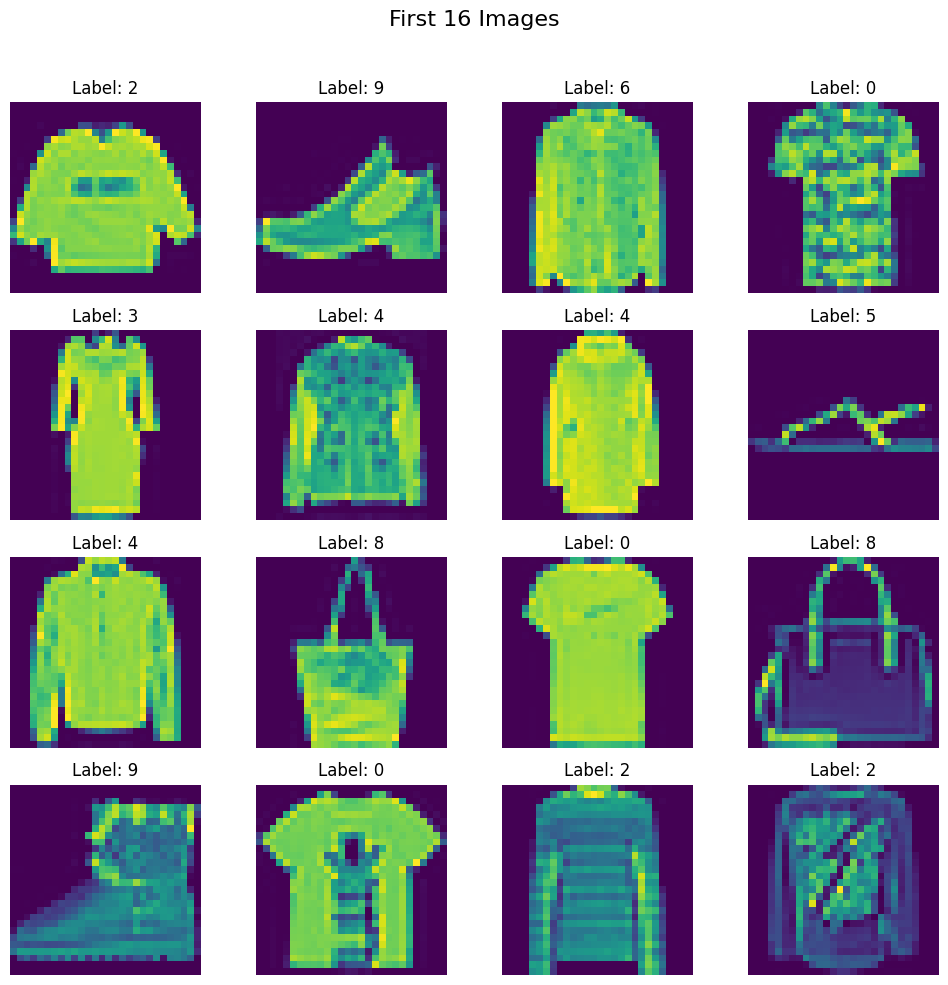

In [27]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [28]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [30]:
X_train= X_train/255.0
X_test= X_test/255.0    

In [31]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [32]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
import torch.nn as nn

In [35]:
class MyNN(nn.Module):
    
  def __init__(self, num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(64, 10)

    )

  def forward(self, x):

    return self.model(x)

In [36]:
learning_rate = 0.1
epochs = 100

In [37]:
# Model
model = MyNN(X_train.shape[1]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=0.9)

In [38]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6132388254006703
Epoch: 2 , Loss: 0.49930071381727853
Epoch: 3 , Loss: 0.4679969795793295
Epoch: 4 , Loss: 0.445178895731767
Epoch: 5 , Loss: 0.4352460973635316
Epoch: 6 , Loss: 0.43107645283142726
Epoch: 7 , Loss: 0.4177304972559214
Epoch: 8 , Loss: 0.4137842709074418
Epoch: 9 , Loss: 0.411760289778312
Epoch: 10 , Loss: 0.4082292765329282
Epoch: 11 , Loss: 0.4048699036737283
Epoch: 12 , Loss: 0.4026845308765769
Epoch: 13 , Loss: 0.395995402003328
Epoch: 14 , Loss: 0.39758978551626206
Epoch: 15 , Loss: 0.3951337173382441
Epoch: 16 , Loss: 0.39079072295874356
Epoch: 17 , Loss: 0.3921637212286393
Epoch: 18 , Loss: 0.4023292020559311
Epoch: 19 , Loss: 0.39449268610775473
Epoch: 20 , Loss: 0.396339796466132
Epoch: 21 , Loss: 0.39001842175920803
Epoch: 22 , Loss: 0.38975556786358356
Epoch: 23 , Loss: 0.3888598582049211
Epoch: 24 , Loss: 0.3975903912037611
Epoch: 25 , Loss: 0.38571903864542645
Epoch: 26 , Loss: 0.3855989470928907
Epoch: 27 , Loss: 0.3880541502883037
Epoch:

In [41]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [39]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8625833333333334


In [40]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.844
